# Using Dynamic IP on the Composable Pipeline
----

<div class="alert alert-box alert-info">
Please use Jupyter labs http://&lt;board_ip_address&gt;/lab for this notebook.
</div>

This notebook shows your how to load dynamic IP and compose branched pipelines

## Aims
* Load dynamic IP
* Compose branched pipelines

## Table of Contents
* [Download Composable Overlay](#download)
* [Start HDMI Video](#start_hdmi)
* [Load Dynamic IP](#dynamic)
* [Let us Compose](#compose)
* [Branched Pipeline](#branched)
* [Conflicting Dynamic IP](#conflicting)
* [Stop HDMI Video](#stop_hdmi)
* [Conclusion](#conclusion)

----

## Revision History

* v1.0 | 30 March 2021 | First notebook revision.
* v1.1 | 11 August 2021 | Update notebook to composable overlay API 1.0.0

----

## Download Composable Overlay <a class="anchor" id="download"></a>

Import the pynq video libraries as well as Composable class and the drivers for the IP.

Download the Composable Overlay using `pynq.Overlay` and grab a handler to the `composable` hierarchy

In [1]:
from pynq import Overlay
from pynq.lib.video import *
from  pynq_composable import *

ol = Overlay("cv_dfx_4_pr.bit")

cpipe = ol.composable

## Start HDMI Video <a class="anchor" id="start_hdmi"></a>

Get `VideoStream` object and start video

<div class="alert alert-heading alert-danger">
    <h4 class="alert-heading">Warning:</h4>

Failure to connect HDMI cables to a valid video source and screen may cause the notebook to hang
</div>

In [2]:
video = VideoStream(ol)
video.start()

## Load Dynamic IP <a class="anchor" id="dynamic"></a>

The Composable Overlay provides DFX regions where IP can be loaded dynamically to bring new functionality. If we want to load an IP within a DFX region, the `.loadIP` method is used. 

Let us start by looking at the `.c_dict` to see what IP cores are loaded

In [3]:
cpipe.c_dict.loaded

{'rgb2gray_accel': {'ci': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'rgb2gray_accel',
  'pi': [2]},
 'gray2rgb_accel': {'ci': [3],
  'dfx': False,
  'loaded': True,
  'modtype': 'gray2rgb_accel',
  'pi': [3]},
 'rgb2hsv_accel': {'ci': [4],
  'dfx': False,
  'loaded': True,
  'modtype': 'rgb2hsv_accel',
  'pi': [4]},
 'filter2d_accel': {'ci': [5],
  'dfx': False,
  'loaded': True,
  'modtype': 'filter2d_accel',
  'pi': [5]},
 'lut_accel': {'ci': [13],
  'dfx': False,
  'loaded': True,
  'modtype': 'LUT_accel',
  'pi': [13]},
 'colorthresholding_accel': {'ci': [14],
  'dfx': False,
  'loaded': True,
  'modtype': 'colorthresholding_accel',
  'pi': [14]},
 'hdmi_source_in': {'ci': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'color_convert',
  'default': True,
  'fullpath': 'video/hdmi_in/color_convert'},
 'hdmi_source_out': {'pi': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'pixel_pack',
  'default': True,
  'fullpath': 'video/hdmi_in/pixel_pack'},
 'hdmi_sink_in'

The documentation of `.loadIP` specify that IP can be loaded using the full name or the IP object

In [4]:
cpipe.loadIP?

Signature: cpipe.loadIP(dfx_list: list) -> None
Docstring:
Download dfx IP onto the corresponding partial regions

Parameters
----------
dfx_list: list
    List of IP to be downloaded onto the dfx regions. The list can
    contain either a string with the fullname or the IP object

    Examples:
        [cpipe.pr_0.fast_accel, cpipe.pr_1.dilate_accel]
        ['pr_0/fast_accel', 'pr_1/dilate_accel']
File:      /usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq_composable/composable.py
Type:      method


In [5]:
cpipe.loadIP([cpipe.pr_1.dilate_accel])

Examine the `.c_dict` again and verify that `dilate_accel` and `erode_accel` are indeed loaded, both are in the same DFX region

In [6]:
cpipe.c_dict.loaded

{'rgb2gray_accel': {'ci': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'rgb2gray_accel',
  'pi': [2]},
 'gray2rgb_accel': {'ci': [3],
  'dfx': False,
  'loaded': True,
  'modtype': 'gray2rgb_accel',
  'pi': [3]},
 'rgb2hsv_accel': {'ci': [4],
  'dfx': False,
  'loaded': True,
  'modtype': 'rgb2hsv_accel',
  'pi': [4]},
 'filter2d_accel': {'ci': [5],
  'dfx': False,
  'loaded': True,
  'modtype': 'filter2d_accel',
  'pi': [5]},
 'lut_accel': {'ci': [13],
  'dfx': False,
  'loaded': True,
  'modtype': 'LUT_accel',
  'pi': [13]},
 'colorthresholding_accel': {'ci': [14],
  'dfx': False,
  'loaded': True,
  'modtype': 'colorthresholding_accel',
  'pi': [14]},
 'pr_1/dilate_accel': {'pi': [8],
  'ci': [8],
  'modtype': 'dilate_accel',
  'bitstream': 'overlay/cv_dfx_4_pr_composable_pr_1_dilate_erode_partial.bit',
  'dfx': True,
  'loaded': True},
 'pr_1/erode_accel': {'pi': [9],
  'ci': [9],
  'modtype': 'erode_accel',
  'bitstream': 'overlay/cv_dfx_4_pr_composable_pr_1_dilate_erode_pa

## Let us Compose <a class="anchor" id="compose"></a>

Grab handlers to the dilate IP and compose

In [7]:
dilate = cpipe.pr_1.dilate_accel

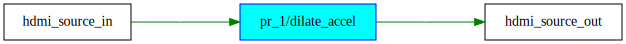

In [8]:
cpipe.compose([cpipe.hdmi_source_in, dilate, cpipe.hdmi_source_out])

cpipe.graph

## Branched Pipeline <a class="anchor" id="branched"></a>

In this part of the notebook, we will bring new functionality into the four DFX regions to compose the [Difference of Gaussians](https://en.wikipedia.org/wiki/Difference_of_Gaussians) application that was also introduced in the previous session. 

Load dynamic IP, grab handlers and set up default values

In [9]:
cpipe.loadIP(['pr_fork/duplicate_accel', 'pr_join/subtract_accel', 'pr_0/filter2d_accel'])

Grab handlers and configure filter2D with the gaussian filter

In [10]:
filter2d = cpipe.filter2d_accel
duplicate = cpipe.pr_fork.duplicate_accel
subtract = cpipe.pr_join.subtract_accel
fifo = cpipe.pr_0.axis_data_fifo_1
filter2d_d = cpipe.pr_0.filter2d_accel

filter2d.sigma = 0.3
filter2d.kernel_type = xvF2d.gaussian_blur

filter2d_d.sigma = 12
filter2d_d.kernel_type = xvF2d.gaussian_blur

The Difference of Gaussians is realized by subtracting one Gaussian blurred version of an original image from another less blurred version of the original. In the Composable Overlay this is achieved by branching the pipeline, which is expressed as a list of a list.

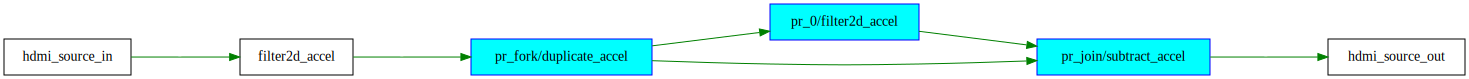

In [11]:
video_pipeline = [cpipe.hdmi_source_in, filter2d, duplicate, [[filter2d_d], [1]], subtract, cpipe.hdmi_source_out]

cpipe.compose(video_pipeline)

cpipe.graph

## Conflicting Dynamic IP <a class="anchor" id="conflicting"></a>

Note that IP within the DFX regions are often mutually exclusive (some partial bitstreams support multiple IP within the DFX region), this means that they cannot be loaded at the same time. The `.loadIP` will raise an exception in these cases, try it by yourself running the following cell

In [12]:
cpipe.loadIP(['pr_fork/duplicate_accel', 'pr_fork/rgb2xyz_accel'])

SystemError: 'cv_dfx_4_pr_composable_pr_fork_duplicate_partial.bit' and 'cv_dfx_4_pr_composable_pr_fork_rgb2xyz_partial.bit' bitstreams cannot be loaded into the same DFX  region 'pr_fork' at the same time

<div class="alert alert-info">
  <strong>Info!</strong> Use the <strong>dfx_dict</strong> attribute to identify which IP are mutually exclusive
</div>

## Stop HDMI Video <a class="anchor" id="stop_hdmi"></a>

Finally stop the HDMI video pipeline

<div class="alert alert-heading alert-danger">
    <h4 class="alert-heading">Warning:</h4>

Failure to stop the HDMI Video may hang the board 
when trying to download another bitstream onto the FPGA
</div>

In [ ]:
video.stop()
ol.free()

----

## Conclusion <a class="anchor" id="conclusion"></a>

This notebook has shown how to bring new functionality to the composable overlay by loading dynamic IP. Moreover, the notebook shows how to implement a branched pipeline.

[⬅️ Modify Composable Pipeline](04_modify_pipeline.ipynb) | | [Build Custom Application ➡️](06_build_application.ipynb)

Copyright &copy; 2021 Xilinx, Inc

SPDX-License-Identifier: BSD-3-Clause

----